### Imports

In [6]:
from data_process.data import Data
from data_process.signal_tools import signal_filter, signal_transform
from data_process.utils import ax_legend_picking, ax_reset_scale
from data_process.detect.rule_based.envelope_threshold import EnvelopeThreshold
import matplotlib.pyplot as plt
import numpy as np
import scipy
%matplotlib widget

### Load and filter data

In [7]:
# pickle_file = '/home/ntkot/theses/ros/bag_db/data_01_10_2023__17_48_46/split1/split1.pkl'

# pickle_file = '/home/ntkot/theses/ros/bag_db/data_19_11_2023__11_50_12/rosbag2_19_11_2023__11_50_12/rosbag2_19_11_2023__11_50_12.pkl'

# pickle_file = '/home/ntkot/theses/ros/bag_db/data_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10.pkl'

pickle_file = '/home/ntkot/Desktop/theses/ros/bag_db/data_07_07_2023__20_18_13/split1/split1_inj.pkl'
# pickle_file = '/home/ntkot/Desktop/theses/ros/bag_db/data_07_07_2023__20_18_13/split2/split2_inj.pkl'

original_data = Data(pickle_file)

sample_rate = 1 / np.average(original_data['time']['rel'][1:] - original_data['time']['rel'][0:-1])
print(f'Sample rate: {sample_rate:.3f}Hz')

accel_wiener_window = 21
accel_highpass_order = 4
accel_highpass_critical_frequency = 3

gyro_wiener_window = 21
gyro_highpass_order = 2
gyro_highpass_critical_frequency = 2

accel_wiener = lambda x: signal_filter.wiener(x, accel_wiener_window)
gyro_wiener  = lambda x: signal_filter.wiener(x, gyro_wiener_window)

accel_filter = lambda x: signal_filter.butterworth(signal=x, 
                                                   sample_rate=sample_rate, 
                                                   order=accel_highpass_order,
                                                   critical_freq=accel_highpass_critical_frequency,
                                                   btype='highpass')
gyro_filter  = lambda x: signal_filter.butterworth(signal=x, 
                                                   sample_rate=sample_rate, 
                                                   order=gyro_highpass_order, 
                                                   critical_freq=gyro_highpass_critical_frequency,
                                                   btype='highpass')

wiener_data = original_data.transform(accel_wiener, [['accel', 'x'], ['accel', 'y'], ['accel', 'z']])
wiener_data.transform(gyro_wiener, [['gyro', 'x'], ['gyro', 'y'], ['gyro', 'z']], in_place=True)

filtered_data = wiener_data.transform(accel_filter, [['accel', 'x'], ['accel', 'y'], ['accel', 'z']])
filtered_data.transform(gyro_filter, [['gyro', 'x'], ['gyro', 'y'], ['gyro', 'z']], in_place=True)

envelope_fun = lambda x: np.abs(signal_transform.hilbert(x))
envelope_data = filtered_data.transform(envelope_fun,  [['accel', 'x'], ['accel', 'y'], ['accel', 'z'], 
                                                        ['gyro', 'x'],  ['gyro', 'y'],  ['gyro', 'z']])

data_dict = {'original': original_data, 'wiener': wiener_data, 'filtered': filtered_data, 'envelope': envelope_data}

Loading from pickle file...
Sample rate: 50.005Hz


### Plot Highpass filter response

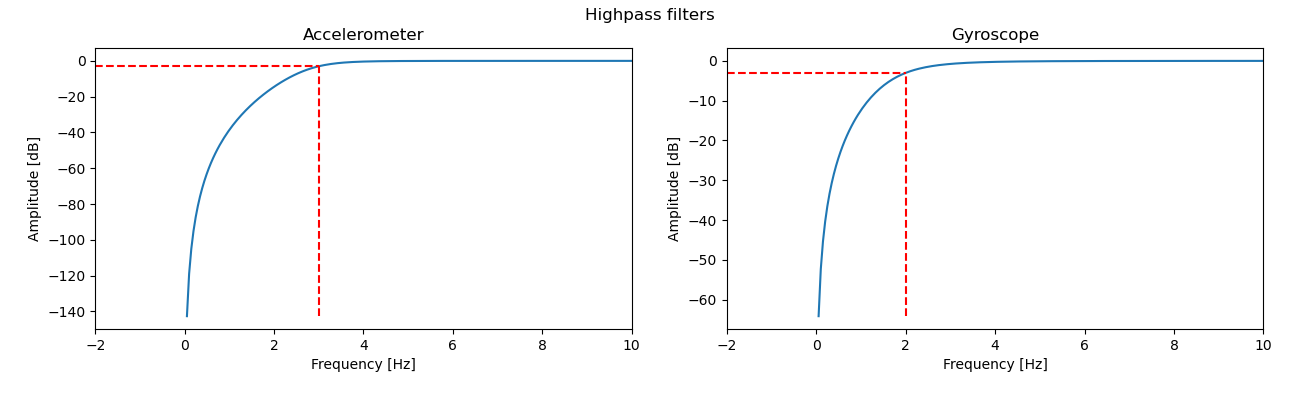

In [8]:
b_accel, a_accel = scipy.signal.butter(N=accel_highpass_order, Wn=accel_highpass_critical_frequency, btype='highpass', fs=sample_rate, output='ba')
b_gyro,  a_gyro  = scipy.signal.butter(N=gyro_highpass_order,  Wn=gyro_highpass_critical_frequency,  btype='highpass', fs=sample_rate, output='ba')
freqs_accel, w_accel = scipy.signal.freqz(b=b_accel, a=a_accel, fs=sample_rate, worN=np.linspace(0.05, sample_rate/2, 512))
freqs_gyro,  w_gyro  = scipy.signal.freqz(b=b_gyro , a=a_gyro , fs=sample_rate, worN=np.linspace(0.05, sample_rate/2, 512))

# PLOTTING
hp_fig = plt.figure(1)
hp_fig.clear()
hp_fig, hp_ax = plt.subplots(num=1, nrows=1, ncols=2)

hp_ax[0].plot(freqs_accel, 20 * np.log10(np.abs(w_accel)))
hp_ax[0].vlines(x=[accel_highpass_critical_frequency], ymin=min(20 * np.log10(np.abs(w_accel))), ymax=-3, color='r', linestyle='--')
hp_ax[0].hlines(y=-3, xmin=-2, xmax=accel_highpass_critical_frequency, color='r', linestyle='--')
hp_ax[0].set_title('Accelerometer')
hp_ax[0].set_ylabel('Amplitude [dB]')
hp_ax[0].set_xlabel('Frequency [Hz]')
hp_ax[0].set_xlim(-2, 10)

hp_ax[1].plot(freqs_gyro, 20 * np.log10(np.abs(w_gyro)))
hp_ax[1].vlines(x=[gyro_highpass_critical_frequency], ymin=min(20 * np.log10(np.abs(w_gyro))), ymax=-3, color='r', linestyle='--')
hp_ax[1].hlines(y=-3, xmin=-2, xmax=gyro_highpass_critical_frequency, color='r', linestyle='--')
hp_ax[1].set_title('Gyroscope')
hp_ax[1].set_ylabel('Amplitude [dB]')
hp_ax[1].set_xlabel('Frequency [Hz]')
hp_ax[1].set_xlim(-2, 10)

hp_fig.set_size_inches(13,4)
hp_fig.tight_layout(pad=2)
hp_fig.suptitle('Highpass filters')

plt.show()

### Before vs After filtering

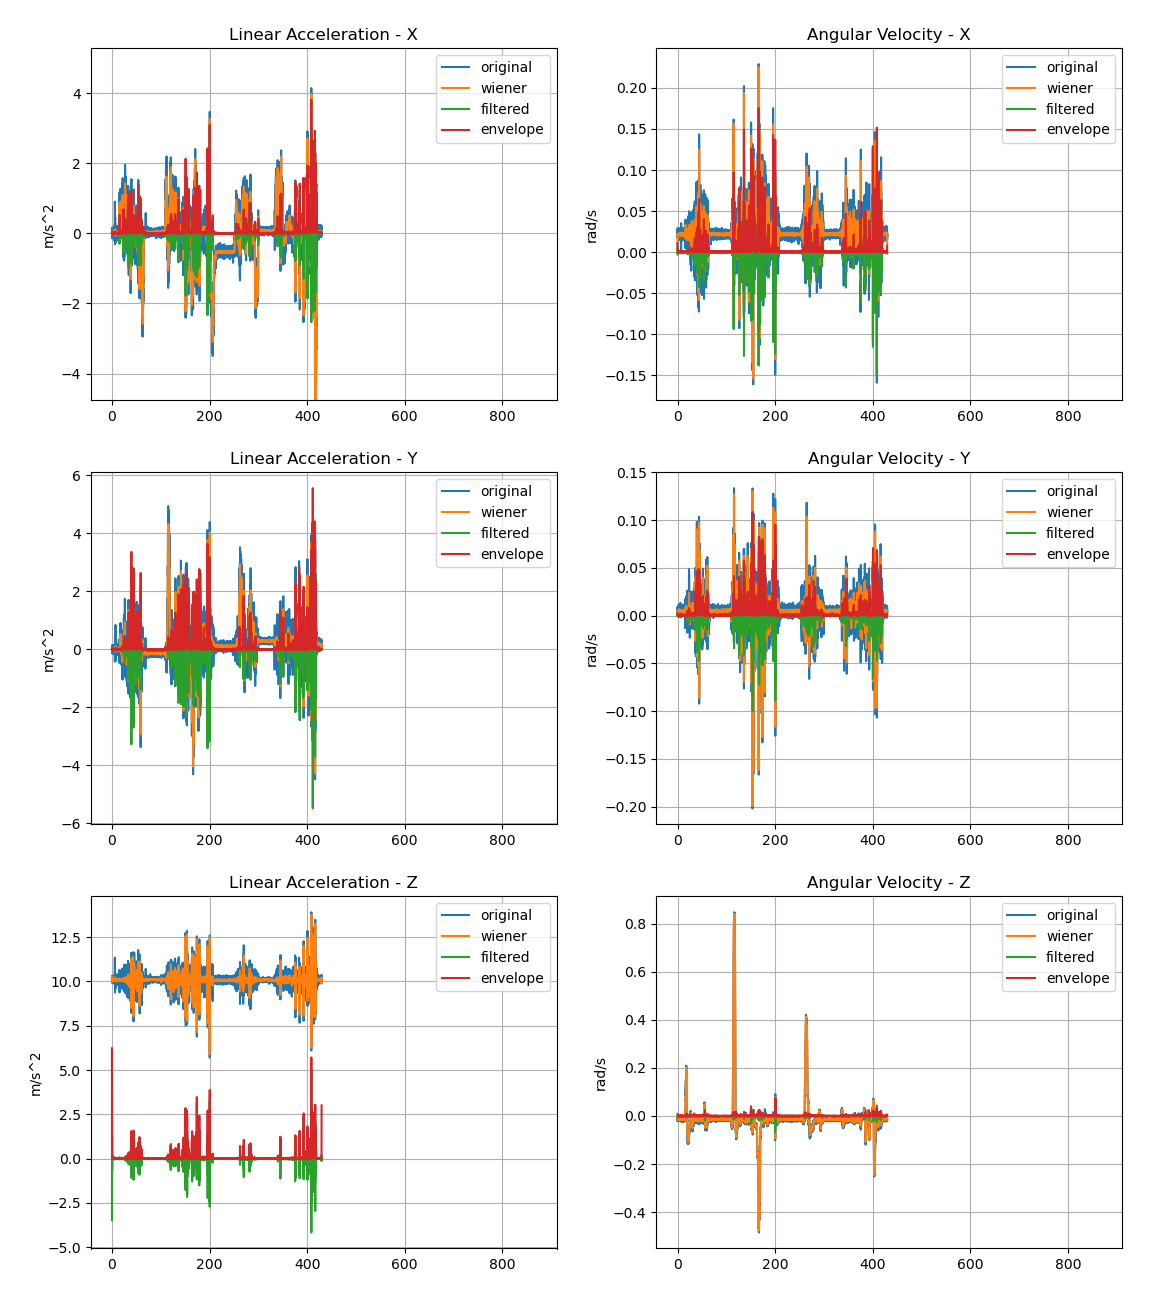

In [9]:
# If figure was created before, keep same x/y axis limits to allow for fast comparisons in time segments
filter_ax_x_lim = None
filter_ax_y_lim = None
if 'filter_ax' in locals():
    filter_ax_x_lim = filter_ax[0][0].get_xlim()
    filter_ax_y_lim = filter_ax[0][0].get_ylim()

filter_fig = plt.figure(2)
filter_fig.clear()
filter_fig, filter_ax = plt.subplots(num=2, nrows=3, ncols=2, sharex='all')

for key in data_dict.keys():
    filter_ax[0][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['x'], label=key)
filter_ax[0][0].grid(which='both', axis='both')
filter_ax[0][0].legend(loc='upper right')
ax_legend_picking(filter_ax[0][0])
filter_ax[0][0].tick_params(labelbottom=True)
filter_ax[0][0].set_ylabel('m/s^2')
filter_ax[0][0].set_title('Linear Acceleration - X')

for key in data_dict.keys():
    filter_ax[1][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['y'], label=key)
filter_ax[1][0].grid(which='both', axis='both')
filter_ax[1][0].legend(loc='upper right')
ax_legend_picking(filter_ax[1][0])
filter_ax[1][0].tick_params(labelbottom=True)
filter_ax[1][0].set_ylabel('m/s^2')
filter_ax[1][0].set_title('Linear Acceleration - Y')

for key in data_dict.keys():
    filter_ax[2][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['z'], label=key)
filter_ax[2][0].grid(which='both', axis='both')
filter_ax[2][0].legend(loc='upper right')
ax_legend_picking(filter_ax[2][0])
filter_ax[2][0].tick_params(labelbottom=True)
filter_ax[2][0].set_ylabel('m/s^2')
filter_ax[2][0].set_title('Linear Acceleration - Z')

for key in data_dict.keys():
    filter_ax[0][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['x'], label=key)
filter_ax[0][1].grid(which='both', axis='both')
filter_ax[0][1].legend(loc='upper right')
ax_legend_picking(filter_ax[0][1])
filter_ax[0][1].tick_params(labelbottom=True)
filter_ax[0][1].set_ylabel('rad/s')
filter_ax[0][1].set_title('Angular Velocity - X')

for key in data_dict.keys():
    filter_ax[1][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['y'], label=key)
filter_ax[1][1].grid(which='both', axis='both')
filter_ax[1][1].legend(loc='upper right')
ax_legend_picking(filter_ax[1][1])
filter_ax[1][1].tick_params(labelbottom=True)
filter_ax[1][1].set_ylabel('rad/s')
filter_ax[1][1].set_title('Angular Velocity - Y')

for key in data_dict.keys():
    filter_ax[2][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['z'], label=key)
filter_ax[2][1].grid(which='both', axis='both')
filter_ax[2][1].legend(loc='upper right')
ax_legend_picking(filter_ax[2][1])
filter_ax[2][1].tick_params(labelbottom=True)
filter_ax[2][1].set_ylabel('rad/s')
filter_ax[2][1].set_title('Angular Velocity - Z')

filter_fig.set_size_inches(11.5,13)
filter_fig.tight_layout(pad=2)

if (filter_ax_x_lim is not None) and (filter_ax_y_lim is not None):
    filter_ax[0][0].set_xlim(filter_ax_x_lim)
    filter_ax[0][0].set_ylim(filter_ax_y_lim)

filter_fig.canvas.mpl_connect('key_press_event', lambda event: ax_reset_scale(event, filter_ax[0][0]))

plt.show()

### Use EnvelopeThreshold detection method on z component of linear acceleration

[[0, 100], [21383, 21483]]
Stats:
  Total points:       21484
  Anomaly points:     3378 (15.72 %) (50 zones)
  Non-anomaly points: 18106 (84.28 %)



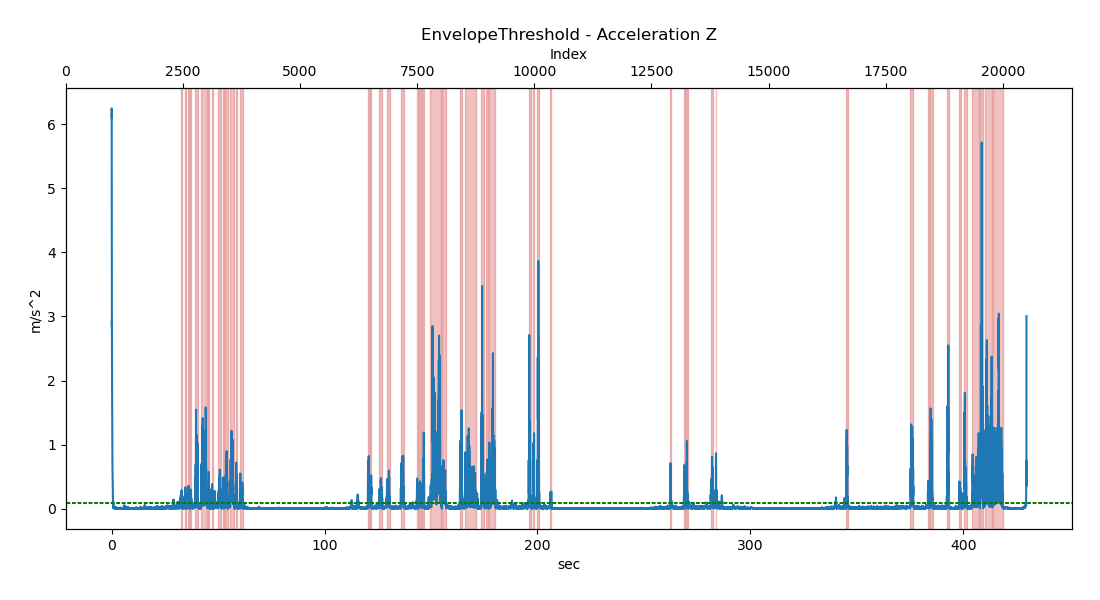

In [11]:
start_value_threshold = 0.11
stop_value_threshold = 0.10
start_counter_threshold = 8
stop_counter_threshold = 10
ignore_ranges = [[0, 100], [-101,-1]]

detector = EnvelopeThreshold(start_value_threshold=start_value_threshold, 
                             stop_value_threshold=stop_value_threshold,
                             start_counter_threshold=start_counter_threshold, 
                             stop_counter_threshold=stop_counter_threshold)
detector.predict(envelope_data['accel']['z'], ignore_ranges)

# STATS/METRICS
anomaly_zones = len(detector.anomalies_start_idx)
anomaly_points = sum([len(range(start, stop+1)) for start, stop in zip(detector.anomalies_start_idx, detector.anomalies_stop_idx)])
non_anomaly_points = len(envelope_data['accel']['z']) - anomaly_points
print(f'Stats:\n' + \
      f'  Total points:       {len(envelope_data["accel"]["z"])}\n' + \
      f'  Anomaly points:     {anomaly_points} ({(anomaly_points / len(envelope_data["accel"]["z"]) * 100.0):.2f} %) ({anomaly_zones} zones)\n' + \
      f'  Non-anomaly points: {non_anomaly_points} ({(non_anomaly_points / len(envelope_data["accel"]["z"]) * 100.0):.2f} %)\n')


# PLOTTING
pred_fig = plt.figure(3)
pred_fig.clear()

plt.plot(envelope_data['time']['rel'], envelope_data['accel']['z'])
plt.axhline(y=start_value_threshold, linestyle='--', color='g', linewidth=0.75)
plt.axhline(y=stop_value_threshold, linestyle='--', color='r', linewidth=0.75)
# plt.scatter(envelope_data['time']['rel'], y_pred, color='r', marker='*', s=6)
for start, stop in zip(detector.anomalies_start_idx, detector.anomalies_stop_idx):
    plt.axvspan(xmin=envelope_data['time']['rel'][start], xmax=envelope_data['time']['rel'][stop], color=(0.8, 0.2, 0.2, 0.3))
plt.xlabel('sec')
plt.ylabel('m/s^2')
plt.title('EnvelopeThreshold - Acceleration Z')

ax_t = pred_fig.axes[0].twiny()
ax_t.set_xlim([0, len(envelope_data['time']['rel']) - 1])
ax_t.set_xlabel('Index')

pred_fig.set_size_inches(11,6)
pred_fig.tight_layout(pad=2)

plt.show()